In [2]:
from qiskit_aer import AerSimulator, StatevectorSimulator
from qiskit.providers.fake_provider import FakeAlmadenV2, FakeSherbrooke
from qiskit.utils import QuantumInstance
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.primitives import Estimator, BackendEstimator, Sampler
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.quantum_info import SparsePauliOp

import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
import pandas as pd


from Components.train import train, train_batch
from Components.data import cancer_data
from Components.circuits import *
from Components.gradients import *

from GLOBAL_CONFIG import *

In [3]:
# Only use in the fist phase

num_qubits = list(range(2, MAX_QUBITS))

# Globak operator for all ansatzes, measure all qubits
G_O = [SparsePauliOp.from_list([('Z'*n, 1)]) for n in num_qubits]

# Local operator for all ansatzes, measere 2 last qubits
L_O = [SparsePauliOp.from_list([('I' * (n - 2)+'Z'*2, 1)]) for n in num_qubits]

In [4]:
# backend = FakeSherbrooke()
# estimator = BackendEstimator(backend)
estimator = Estimator()

In [5]:
X_train, X_val, y_train, y_val = cancer_data(PCA_n = FEATURE_DIM)
# X_train, X_val, y_train, y_val = fetch_mnist(PCA_n = FEATURE_DIM, data_size=DATA_SIZE)
# X_train, X_val, y_train, y_val = iris(pd=False, PCA_n=None)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

Training set: 398 samples
Testing set: 171 samples
Number of features: 4
PCA Explained variance: [4.43782605e+05 7.31010006e+03 7.03833742e+02 5.46487379e+01]
Classes:[0 1]; Encoded as: [-1  1]


In [6]:
anz = AnsatzGenerator(num_qubits = MAX_QUBITS, reps = MAX_REPS, entanglement='linear')
print("Ansatz Method 0 stats:")
print(f"{' - Parameters:':<20} {anz.num_parameters: >5}")
print(f"{' - Depth:':<20} {anz.decompose().depth(): >5}")

print('\n')

ibl = preTrainedBlockGenerator(num_qubits = MAX_QUBITS, num_blocks = 3, overlay = 2)['circuit']
print("Identity Block Method 3 stats:")
print(f"{' - Parameters:':<20} {ibl.num_parameters: >5}")
print(f"{' - Depth:':<20} {ibl.depth(): >5}")

Ansatz Method 0 stats:
 - Parameters:         156
 - Depth:               46


Identity Block Method 3 stats:
 - Parameters:         156
 - Depth:               96


/home/ncng/.local/share/virtualenvs/VQA-Notes-v2-sVJD73WG/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


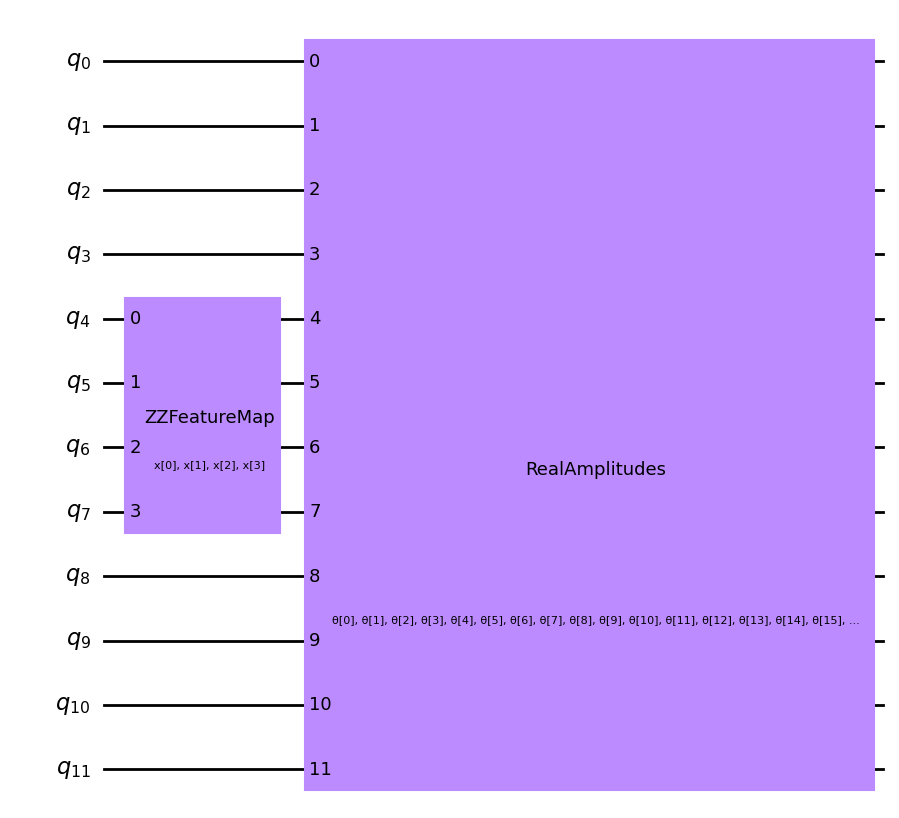

In [10]:
feature_map = featureMapGenerator(FEATURE_DIM)
ansatz = AnsatzGenerator(MAX_QUBITS, MAX_REPS, ENTANGLEMENT)

experimental_qc = circuitBuilder(feature_map, ansatz, 'middle')
experimental_qc.draw('mpl')

In [11]:
def LLMinimizePrimitives(circuit: QuantumCircuit, optimiser:optimizers, estimator: Estimator):
    operator = SparsePauliOp.from_list([('I' * (circuit.num_qubits - 2)+'Z'*2, 1)])

    initial_point = np.zeros(circuit.num_parameters)

    bouned_circuit = circuit.assign_parameters(initial_point)

    expectation = Statevector(bouned_circuit)
    
    state = expectation.evolve(operator)

    PShiftGradient = ParamShiftEstimatorGradient(state)

    def loss(x):
        # values = dict(zip(circuit.parameters, x))
        return np.real(estimator.run([circuit], observables=[operator], parameter_values=[x]).result().values)
    
    def gradient(x):
        # values = dict(zip(circuit.parameters, x))
        return np.real(PShiftGradient.run(parameter_values=[x]))

    res = optimiser.minimize(fun=loss, jac=gradient, x0=initial_point)

    return res


def LayerwiseTrainingPrimitives(ansatz: QuantumCircuit, max_num_layers: int, optimizer = COBYLA(maxiter=5), estimator = Estimator()):
    optimal_parameters = []

    for reps in range(1, max_num_layers+1):
        ansatz.reps = reps

        # bind already optimized parameters
        values_dict = dict(zip(ansatz.parameters, optimal_parameters))
        partially_bound = ansatz.assign_parameters(values_dict)

        res = LLMinimizePrimitives(partially_bound, optimizer, estimator)
        print('Circuit rep:', reps, 'best value:', res.fun)
        optimal_parameters += list(res.x)

    return optimal_parameters


# feature_map = featureMapGenerator(FEATURE_DIM)
# ansatz = AnsatzGenerator(2, reps=3, entanglement=ENTANGLEMENT)

# initial_point = LayerwiseTrainingPrimitives(ansatz, MAX_REPS, optimizer=COBYLA(maxiter=50), estimator=Estimator())

In [9]:
qnn = EstimatorQNN(
    circuit=experimental_qc,
    estimator=estimator,
    observables=GLOBAL_OPERATOR,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters
)

In [10]:
model = TorchConnector(qnn)
loss_function = nn.L1Loss() # nn.MSELoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

model, losses, accuracy_train, accuracy_test, weights = train(
    model, 
    10, 
    X_train_t,
    y_train_t,
    X_val_t,
    y_val_t,
    optimizer = optimizer, 
    loss_function = loss_function
)

Epoch      Loss                 Train Accuracy   Test Accuracy   


In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(8)

data = [pd.DataFrame(accuracy_test).astype('float').T]
# Plot data
for i in range(len(data)):
    data[i].T.plot(ax=ax, label=f'inst# {i}', figsize=(5, 3))
ax.legend([f'inst {i}' for i in range(len(data))])
plt.title('instace losses')
plt.show()  